# Description

A insurance company wants to address several issues with the help of machine learning. You are also asked to evaluate the feasibility of these tasks.
- Task 1: Find clients similar to specific client criteria. This task will facilitate the company's marketing efforts.
- Task 2: Predict whether new clients are likely to make insurance claims. Is the model's prediction better than that of a dummy model?
- Task 3: Predict the amount of insurance claims that new clients might receive using a linear regression model.
- Task 4: Protect the personal data of clients without compromising the model from the previous tasks. It is crucial to develop data transformation algorithms that can prevent the misuse of clients' personal information if it falls into the wrong hands. This is called data masking or data obfuscation. However, data protection procedures should also be considered to ensure that the quality of the machine learning model does not deteriorate. Here, you do not need to choose the best model; just prove that your algorithm works accurately.

# Pre-processing and Data Eksploration

## Initialization

In [1]:
#pip install scikit-learn --upgrade

In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors 
import sklearn.preprocessing
import matplotlib.pyplot as plt

from scipy.spatial import distance

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from IPython.display import display

## Import Data

Import the data and perform checks to ensure that the data is free from issues.

In [3]:
try:
    df = pd.read_csv('D:/datasets/insurance_us.csv')
except:
    df = pd.read_csv('/datasets/insurance_us.csv')

I renamed the columns to make the code appear more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
660,0,39.0,49300.0,0,0
4291,0,25.0,44500.0,0,0
4127,0,20.0,38400.0,4,0
2370,1,39.0,49300.0,3,0
2318,0,35.0,42500.0,0,0
1637,0,39.0,55000.0,1,0
3026,0,24.0,38500.0,0,0
957,0,27.0,42300.0,2,0
20,1,38.0,43500.0,1,0
3986,1,21.0,38500.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# I may want to change the data type for the "age" column (from float to int), but this is not very important to do

# The code to change the data type is here if you choose to do so:
df['age'] = df['age'].astype('int64')

In [8]:
# Check whether the conversion process has been successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# Now, observe the descriptive statistics of the data
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


From the data description above, we can gain the following insights:
- In the `age` and `income` columns, the standard deviation values are significantly far from the mean values. This indicates that the data in these columns have low variability.
- Regarding quartile values, in the `gender` column, there are more 0 values than 1 values. And the age group that claims insurance the most falls within the range of 24 to 30 years.
- As for the `income` values, the lowest income claimed for insurance is at least 46,600. Based on the number of family members, those who claim insurance the least are already married or have a family.

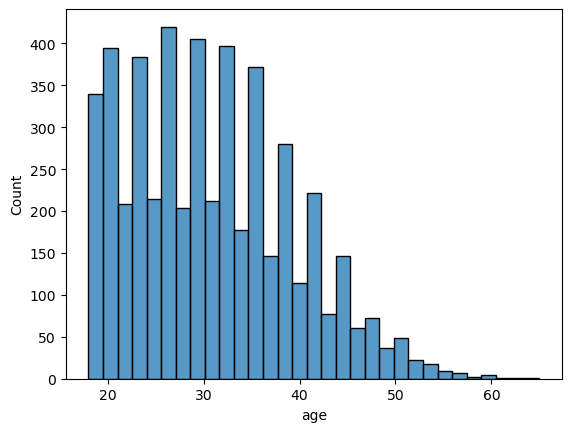

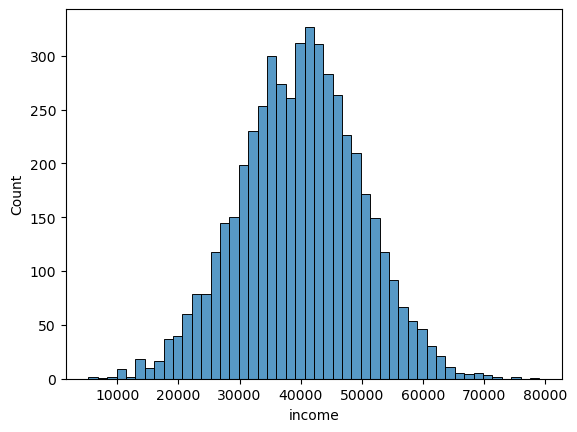

In [10]:
# create histogram
for column in df.drop(['gender', 'family_members', 'insurance_benefits'], axis=1).columns:
    sns.histplot(data=df[column])
    plt.show()

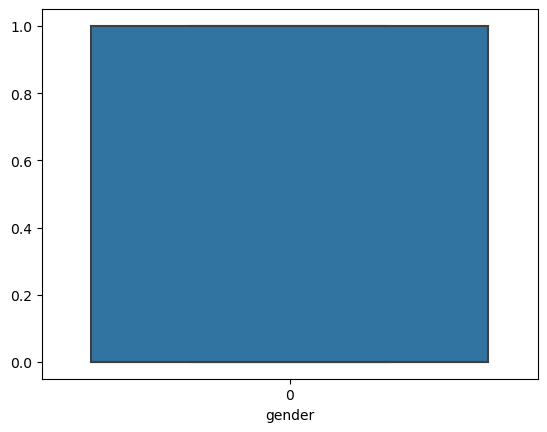

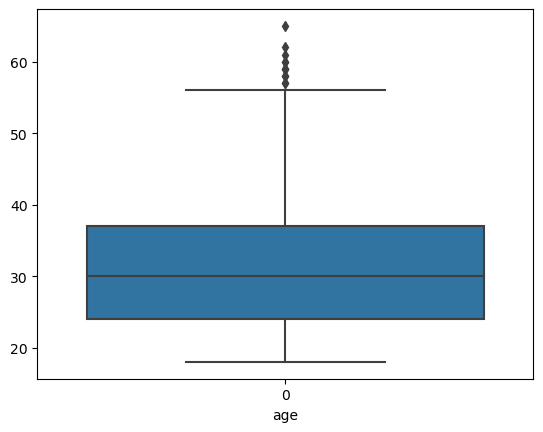

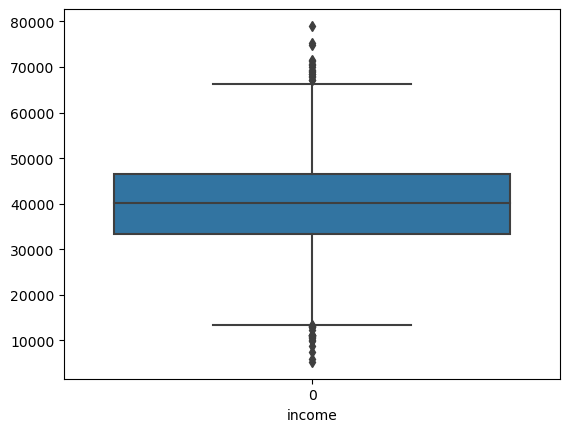

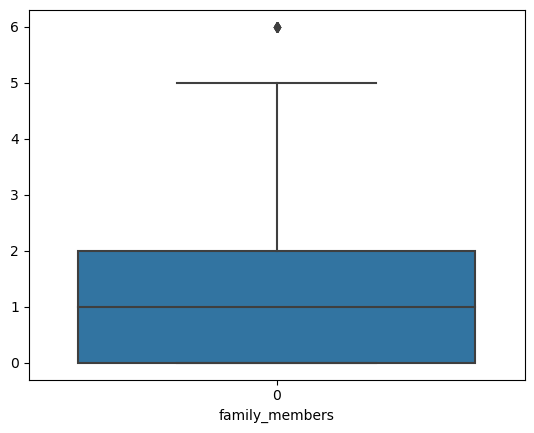

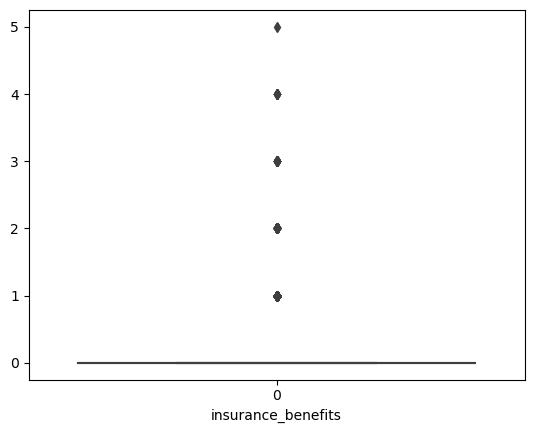

In [11]:
# create boxplot
for column in df.columns:
    sns.boxplot(data=df[column])
    plt.xlabel(column)
    plt.show()

From the data visualization results above, we can see that there are some columns with outliers, such as in the `age`, `income`, `family_members`, and `income_benefits` columns. However, these outlier values will not be removed because they are not highly significant, and the data in these columns holds important value for future analysis.

## EDA

Are there any specific customer groups identifiable by examining the pair plot?

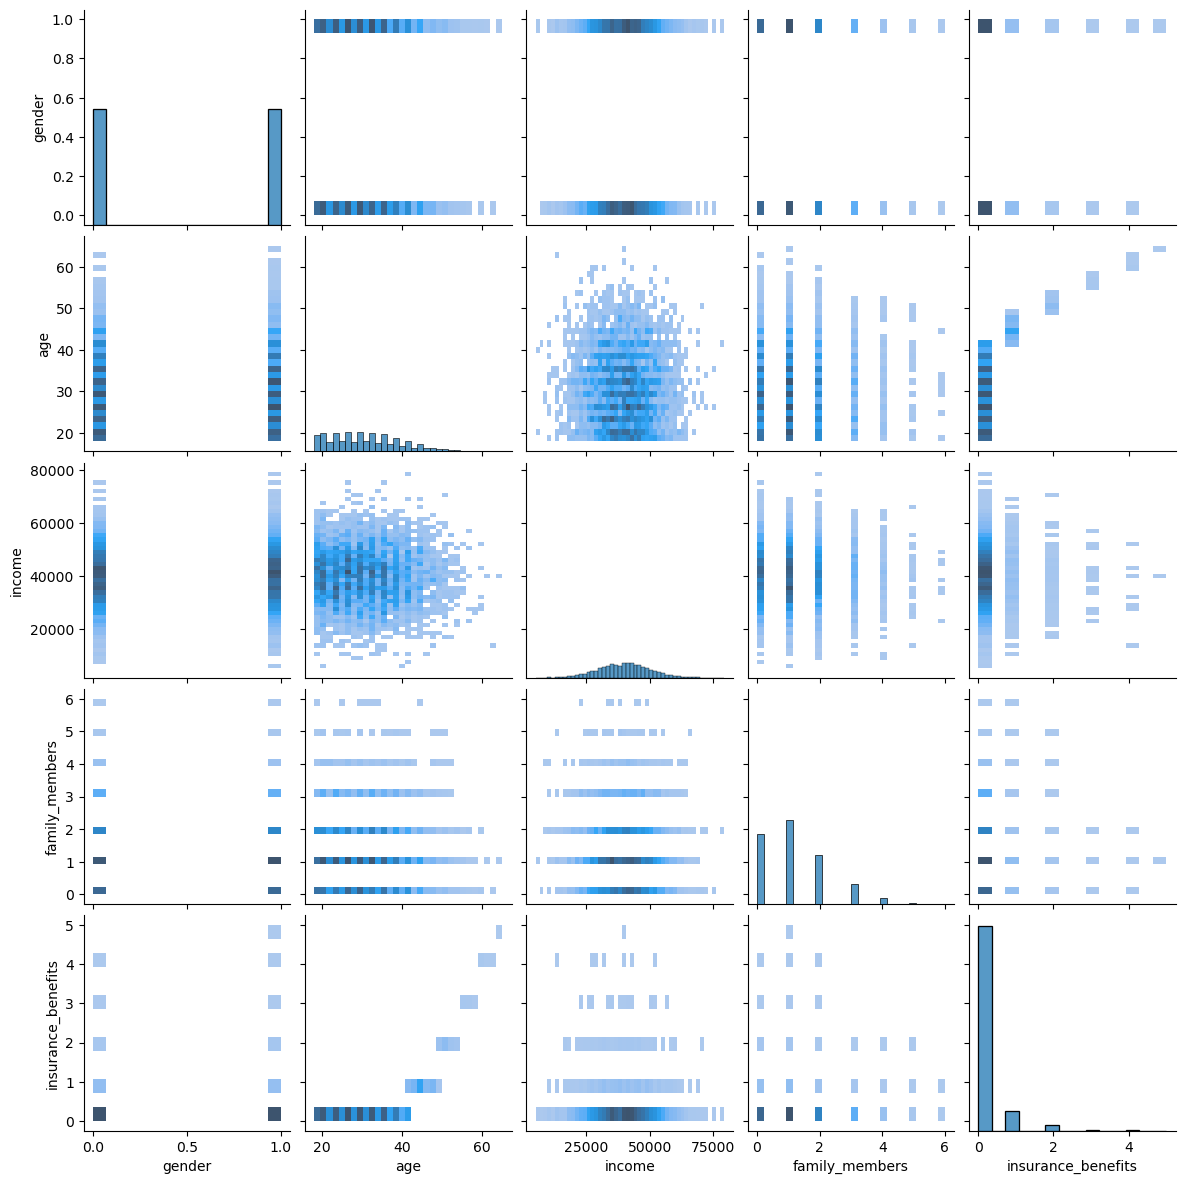

In [12]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Alright, it seems a bit challenging to identify clear clusters given the difficulty of combining multiple variables simultaneously (for analyzing multivariate distributions). However, that's where Machine Learning and Data Analytics come into play here.

# Task 1: Similar Clients

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [14]:
def get_knn(df, n, k, metric):
    
    """
    Displaying k Nearest Neighbors

    :param df: Pandas DataFrame used to find similar objects within it
    :param n: the number of objects to find k nearest neighbors for
    :param k: the number of k nearest neighbors to display
    :param metric: the name of the distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the Data.

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [16]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
260,1.0,0.646154,0.591139,0.000000,1
1408,0.0,0.538462,0.478481,0.000000,0
2417,0.0,0.307692,0.789873,0.000000,0
2338,1.0,0.415385,0.581013,0.000000,0
3348,0.0,0.384615,0.592405,0.166667,0


Now, let's obtain records that are similar for each existing combination.

In [17]:
n = np.random.randint(0, len(df_scaled))
print(n)

1457


In [18]:
get_knn(df, n, 5, 'manhattan')

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
1457,0,18,38600.0,0,0,0.0
1751,0,19,38600.0,0,0,1.0
3268,0,19,38600.0,0,0,1.0
900,0,18,38600.0,2,0,2.0
921,1,20,38600.0,0,0,3.0


In [19]:
get_knn(df, n, 5, 'manhattan')

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
1457,0,18,38600.0,0,0,0.0
1751,0,19,38600.0,0,0,1.0
3268,0,19,38600.0,0,0,1.0
900,0,18,38600.0,2,0,2.0
921,1,20,38600.0,0,0,3.0


In [20]:
get_knn(df_scaled, n, 5, 'euclidean')

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
1457,0.0,0.276923,0.488608,0.0,0,0.000000
139,0.0,0.276923,0.500000,0.0,0,0.011392
1751,0.0,0.292308,0.488608,0.0,0,0.015385
3268,0.0,0.292308,0.488608,0.0,0,0.015385
4217,0.0,0.276923,0.506329,0.0,0,0.017722


In [21]:
get_knn(df_scaled, n, 5, 'manhattan')

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
1457,0.0,0.276923,0.488608,0.0,0,0.000000
139,0.0,0.276923,0.500000,0.0,0,0.011392
1751,0.0,0.292308,0.488608,0.0,0,0.015385
3268,0.0,0.292308,0.488608,0.0,0,0.015385
4217,0.0,0.276923,0.506329,0.0,0,0.017722


**Does unscaled data affect the kNN algorithm? If it does, what is the impact?**

Unscaled data does affect the kNN algorithm. When we look at unscaled data, the shape of the distance is larger, and this significantly impacts the performance of kNN. In contrast, for scaled data sets, the distances are smaller and not spread out as much.

**How similar are the results you obtained using the Euclidean metric compared to when you used the Manhattan distance metric (regardless of scaling)?**

The results from both metrics are very similar. There is no difference in the outcomes of the two metrics, as the only distinction between them is how they calculate distance.

# Task 2. Predicting Whether Clients Are Likely to Receive Insurance Claims?

With the target of insurance_benefits greater than zero, let's evaluate whether the kNN classification model is a better approach than a dummy model.

Instructions:
- Create KNN-based classifiers and measure their quality using the F1 metric for k=1..10 for both the original and scaled data. It will be interesting to see how k affects the evaluation metric and whether data scaling makes a difference. Use the kNN classification algorithm implementation available in Scikit-learn (check [this link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.

- Create a random *dummy* model for this case. The model should output "1" with some probability. Let's test the model with four probability values: 0, no probability of paying any insurance benefit; 0.5; 1.

The probability of paying an insurance claim can be defined as:

$$
P\{\text{insurance claim received}\}=\frac{\text{number of clients who received insurance claims}}{\text{total number of clients}}.
$$

Separate the entire data into a 70:30 split for the training and test sets proportion.

In [22]:
# Calculate The Target
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype('Int64')
df.head()

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
1,0,46,38000.0,1,1,1
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0


0    4436
1     564
Name: insurance_benefits_received, dtype: Int64


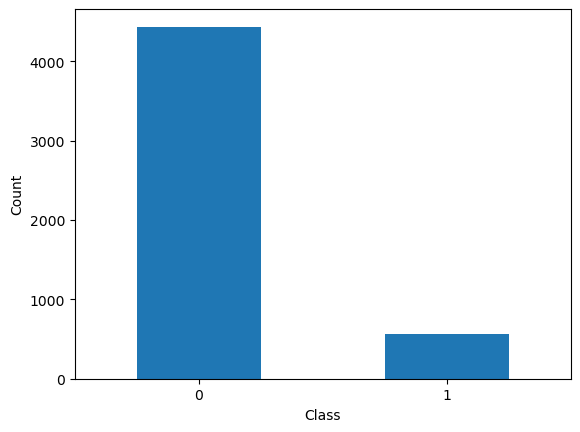

In [23]:
# Check for class imbalance using the `value_counts()` method.

class_counts = df['insurance_benefits_received'].value_counts()
print(class_counts)

class_counts.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=360)
plt.show()

In [24]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matrix of Errors')
    print(cm)

In [25]:
# Generate the output from the random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [26]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'Probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

Probability: 0.00
F1: 0.00
Matrix of Errors
[[0.8872 0.    ]
 [0.1128 0.    ]]

Probability: 0.11
F1: 0.12
Matrix of Errors
[[0.7914 0.0958]
 [0.0994 0.0134]]

Probability: 0.50
F1: 0.20
Matrix of Errors
[[0.456  0.4312]
 [0.053  0.0598]]

Probability: 1.00
F1: 0.20
Matrix of Errors
[[0.     0.8872]
 [0.     0.1128]]



Based on the information above, it can be concluded that:
- For a probability of 0, the F1 score obtained is 0, which means the model performs poorly in predicting positive values. We can see a very high value for `true negatives`.
- For a probability of 0.11, the F1 score obtained is 0.12, indicating that the model's performance is still relatively poor in predicting positive values. It can be observed that the `true negatives` are much higher compared to the `true positives`.
- For a probability of 0.5, an F1 score of 0.20 is obtained. The model still performs poorly because it predicts more `true negatives`.
- For a probability of 1, the F1 score obtained is 0.20. The model performs well in predicting positive values. However, it predicts more `false positives`.

The above observations can occur because the data or target variable has imbalanced classes between class 0 and 1.

# Task 3. Regression (with Linear Regression)

Dengan `insurance_benefit` sebagai target, evaluasi berapa RMSE untuk model Regresi Linear.

Create your own implementation of Linear Regression (LR). For this, try to recall how the solution for linear regression tasks is formulated in the form of Linear Algebra (LA). Calculate the Root Mean Square Error (RMSE) for both the original and scaled data. Can you observe any differences in RMSE between the two cases?

Tunjukkan
- $X$ — The feature matrix, where each row represents one case and each column represents a feature, with the first column consisting of units.
- $y$ — target (vector)
- $\hat{y}$ — target estimation (vector)
- $w$ — vector weight

The matrix for linear regression can be formulated as follows

$$
y = Xw
$$

The training objective is to find the vector $w$ that minimizes the L2 distance (Mean Squared Error - MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It seems like there is an analytical solution to the problem above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$, and the latter can be used to calculate the prediction values:

$$
\hat{y} = X_{val}w
$$

Separate the entire data into a training set and a validation set with a 70:30 ratio. Use the RMSE metric for model evaluation.

In [27]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # menambahkan satuan
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # menambahkan satuan
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [28]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [29]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [30]:
lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [31]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


**Based on the testing above, we can conclude:** When using unscaled data, the RMSE testing results show a value of 0.34, indicating that the model has a fairly good ability to predict `insurance_benefit`. As for the R2 value, the model achieves around 66%. The R2 value is still relatively low but decent. When using the scaled data, the testing results are the same as before, both in terms of RMSE and R2 values.

# Task 4. Data Obfuscation

The best way to obfuscate data is by multiplying the numeric features (remember that these features can be seen in the matrix $X$) with an invertible matrix $P$.

$$
X' = X \times P
$$

Let's do that and see how the feature values will look after the transformation. The invertibility property is crucial in this case, so make sure that $P$ is invertible.

You may want to review the lesson on 'Matrices and Matrix Operations -> Matrix Multiplication' to recall the rules of matrix multiplication and implement it using NumPy.

In [32]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [33]:
X = df_pn.to_numpy()

Creating a random matrix $P$.

In [34]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking whether the matrix $P$ is invertible.

In [35]:
determinant = np.linalg.det(P)

if determinant != 0:
    print("Matriksnya Invertible")
else:
    print("Matriksnya Non-invertible")

Matriksnya Invertible


In [36]:
Xt = X @ P
Xt

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Can you guess the age of the clients or their income after the transformation?

In [37]:
dft = pd.DataFrame(Xt, columns=df_pn.columns)
df2 = pd.concat([df_pn, dft], axis=1, keys=['original', 'transformed'])
df2.head()

original                              transformed                \
    gender age   income family_members       gender           age   
0        1  41  49600.0              1  6359.715273  22380.404676   
1        0  46  38000.0              1  4873.294065  17160.367030   
2        0  29  21000.0              0  2693.117429   9486.397744   
3        0  21  41700.0              2  5345.603937  18803.227203   
4        1  28  26100.0              0  3347.176735  11782.829283   

                                
         income family_members  
0  18424.090742   46000.696690  
1  14125.780761   35253.455773  
2   7808.831560   19484.860631  
3  15479.148373   38663.061863  
4   9699.998942   24211.273378

Since the data has been transformed using the matrix $P$, it will be difficult to guess the age of the clients or their income.

Can you recover the original data from $X'$ if $P$ is known? Try to check this through calculations by moving $P$ from the right side of the formula above to the left side. The rules of matrix multiplication are very useful here.

In [38]:
P_inv = np.linalg.inv(P)
Xn = Xt @ P_inv

Show the three cases for a few clients:
1. Original data
2. Transformed data
3. Recovered data to its original state

In [39]:
dfr = pd.DataFrame(Xn, columns=df_pn.columns)
df3 = pd.concat([df_pn, dft, dfr], axis=1, keys=['original', 'transformed', 'inverse'])
df3.head()

original                              transformed                \
    gender age   income family_members       gender           age   
0        1  41  49600.0              1  6359.715273  22380.404676   
1        0  46  38000.0              1  4873.294065  17160.367030   
2        0  29  21000.0              0  2693.117429   9486.397744   
3        0  21  41700.0              2  5345.603937  18803.227203   
4        1  28  26100.0              0  3347.176735  11782.829283   

                                     inverse                                
         income family_members        gender   age   income family_members  
0  18424.090742   46000.696690  1.000000e+00  41.0  49600.0   1.000000e+00  
1  14125.780761   35253.455773 -3.183231e-12  46.0  38000.0   1.000000e+00  
2   7808.831560   19484.860631  1.364242e-12  29.0  21000.0   0.000000e+00  
3  15479.148373   38663.061863 -3.637979e-12  21.0  41700.0   2.000000e+00  
4   9699.998942   24211.273378  1.000000e+00  28.0  26100.0   3.637979e-12

You might notice that there are some values that are not exactly the same as the data before transformation. Why is this the case?

This can happen because in matrix multiplication using floating-point numbers, computers have limitations in providing precise floating-point values. When performing matrix multiplication and inversion, rounding errors can occur.

##  Prove That Data Obfuscation Can Work with Linear Regression

The regression task in this project has been completed using linear regression. The next task is to analytically prove that a specific data obfuscation method will not affect the predictions of linear regression values - the prediction values will not change from their initial results. Are you confident that you can do it? You don't have to be sure now, but you should prove it!

So, the existing data has been obfuscated, and now there is $X \times P$ instead of just $X$. As a result, there is another weight vector $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How do you relate $w$ and $w_P$ if you simplify the formula for $w_P$ above?

What values will $w_P$ predict?

What does it mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B (Matrix Properties) in the notebook. There are some useful formulas there!

There's no code that's particularly crucial in this session, just analytical explanations!

**Answer**

The result of Linear Regression when using obfuscated data is the same as the result when the data was not obfuscated.

**Analytical proof**

We have:
$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Because:
$$
(AB)^T = A^T B^T
$$

Then:
$$
w_P = [(X^T P^T) XP]^{-1} (XP)^T y
$$

Because:
$$
(AB)^{-1} = A^{-1} B^{-1}
$$

Then:
$$
w_P = P^{-1} (X^T P^T X)^{-1} (XP)^T y
$$

$$
w_P = P^{-1} (X^T X)^{-1} X^T (P^T)^{-1} P^T y
$$

Because:
$$
A^{-1} A = I
$$

Then:
$$
w_P = P^{-1} (X^T X)^{-1} X^T y
$$

Remember that:
$$
w = (X^T X)^{-1} X^T y
$$

Then:
$$
w_P = P^{-1} w
$$

To prove that the values generated by $w_P$ are the same as $w$, it will be demonstrated that:

$$
y_P = y
$$

Given: $y_P = X' w_P$

Remember that:
$$
y = X w
$$

$$
X' = X P
$$

$$
w_P = P^{-1} w
$$

Then:
$$
y_P = X P P^{-1} w
$$

$$
y_P = X w
$$

$$
y_P = y
$$

So, it has been analytically proven that data transformation using a matrix will not change the results in Linear Regression.

## Test Linear Regression with Data Obfuscation

Now, let's prove that Linear Regression can work computationally with the chosen data obfuscation transformation.

Create a procedure or class that performs linear regression with data obfuscation. You can use linear regression available in scikit-learn or your own implementation.

Run linear regression on the original data and the obfuscated data, compare the prediction values and RMSE, as well as the $R^2$ metric. Are there any differences?

In [40]:
df_transformed = dft.reset_index(drop=True).join(df['insurance_benefits'])
df_transformed.head()

,gender,age,income,family_members,insurance_benefits
0,6359.715273,22380.404676,18424.090742,46000.696690,0
1,4873.294065,17160.367030,14125.780761,35253.455773,1
2,2693.117429,9486.397744,7808.831560,19484.860631,0
3,5345.603937,18803.227203,15479.148373,38663.061863,0
4,3347.176735,11782.829283,9699.998942,24211.273378,0


In [41]:
features_t = df_transformed.drop(['insurance_benefits'], axis=1)
target_t = df_transformed['insurance_benefits']

Xt_train, Xt_test, yt_train, yt_test = train_test_split(features_t, target_t, test_size=0.3, random_state=12345)

In [42]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(Xt_train, yt_train)
predict = model.predict(Xt_test)

In [43]:
print("Sebelum Transformasi")
eval_regressor(y_test, y_test_pred)
print()
print("Setelah Transformasi")
eval_regressor(yt_test, predict)

Sebelum Transformasi
RMSE: 0.34
R2: 0.66

Setelah Transformasi
RMSE: 0.34
R2: 0.66


As seen, the RMSE and R2 values obtained are not different. This means that the data that has not been transformed and the transformed data are the same and do not affect the performance of the linear regression model.

# Conclusion

**The conclusions obtained are:**
- The kNN model using Euclidean and Manhattan distance metrics yields similar results.
- Unscaled data compared to scaled data significantly affects the performance of kNN.
- There is an imbalanced class issue that affects the kNN model's classification.
- In the Linear Regression model, the model achieves an RMSE of 0.34 and an R2 of 0.66.
- Data transformation does not show any change in the performance of the Linear Regression model.

# Appendix

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in a Jupyter Notebook using the markup language provided by the high-quality typesetting system called $\LaTeX$ (pronounced "Lay-tech"), and the formulas will appear like those in textbooks.

To embed formulas in text, enclose the formula text with dollar signs (\\$) before and after the formula text. For example: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula needs to be written in a separate paragraph, use double dollar signs (\\$\\$) before and after the text.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

Markup language [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is highly popular among people who use formulas in articles, books, and texts. While the language may appear complex, the basics are actually quite simple. heck out the following [two cheatsheet pages](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) to learn how to create the most common formulas.

## Appendix B: Matrix Properties

Matrices have many properties in Linear Algebra. Some of them are listed in the following list, which can be helpful for analytical proofs in this project.

<table>
<tr>
<td>Distribution</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Identity property of multiplication</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibility of the matrix multiplication transpose</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>